# Movie Interest Prediction – EDA & Baseline Model

This notebook explores the integrated MovieLens 100K + TMDB 5000 dataset, performs data cleaning and feature engineering, and trains a baseline KNN recommender as the foundation for subsequent submissions.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.data import build_enriched_ratings
from src.features import FeatureBuilder
from src.modeling import evaluate_regression, user_stratified_split, cold_start_mask, fit_baseline_knn

In [2]:
sns.set_theme(style="whitegrid", palette="deep")
DATA_DIR = Path(".") / "Data"
ML_PATH = DATA_DIR / "ml-100k"
TMDB_PATH = DATA_DIR / "TMDB-5000"

## 1. Load and Inspect the Enriched Dataset


In [3]:
ratings_df = build_enriched_ratings(ML_PATH, TMDB_PATH)
ratings_df.head()

,user_id,movie_id,rating,timestamp,title,release_date,imdb_url,genres_list,top_cast,tmdb_movie_id,...,tmdb_release_date,tmdb_vote_average,tmdb_vote_count,popularity,title_clean,release_year,age,gender,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,kolya,1997.0,49,M,writer,55105
1,186,302,3,891717742,L.A. Confidential (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,"[Crime, Drama, Mystery, Thriller]","[Kevin Spacey, Guy Pearce, Danny DeVito, James...",2118.0,...,1997-09-19,7.7,1310.0,24.860326,l a confidential,1997.0,39,F,executive,00000
2,22,377,1,878887116,Heavyweights (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Heavyweights%...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,heavyweights,1994.0,25,M,writer,40206
3,244,51,2,880606923,Legends of the Fall (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Legends%20of%...,"[Adventure, Drama, Romance, War]","[Brad Pitt, Anthony Hopkins, Aidan Quinn, Juli...",4476.0,...,1994-12-16,7.2,619.0,26.952727,legends of the fall,1994.0,28,M,technician,80525
4,166,346,1,886397596,Jackie Brown (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?imdb-title-11...,"[Comedy, Crime, Romance]","[Pam Grier, Samuel L. Jackson, Robert Forster,...",184.0,...,1997-12-24,7.3,1514.0,40.631671,jackie brown,1997.0,47,M,educator,55113


In [4]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            100000 non-null  int64  
 1   movie_id           100000 non-null  int64  
 2   rating             100000 non-null  int64  
 3   timestamp          100000 non-null  int64  
 4   title              100000 non-null  object 
 5   release_date       99991 non-null   object 
 6   imdb_url           99987 non-null   object 
 7   genres_list        42211 non-null   object 
 8   top_cast           42211 non-null   object 
 9   tmdb_movie_id      42211 non-null   float64
 10  tmdb_budget        42211 non-null   float64
 11  tmdb_runtime       42211 non-null   float64
 12  tmdb_overview      42211 non-null   object 
 13  tmdb_release_date  42211 non-null   object 
 14  tmdb_vote_average  42211 non-null   float64
 15  tmdb_vote_count    42211 non-null   float64
 16  pop

In [5]:
ratings_df.describe(include="all").transpose().head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,100000.0,NaN,NaN,NaN,462.48475,266.61442,1.0,254.0,447.0,682.0,943.0
movie_id,100000.0,NaN,NaN,NaN,425.53013,330.798356,1.0,175.0,322.0,631.0,1682.0
rating,100000.0,NaN,NaN,NaN,3.52986,1.125674,1.0,3.0,4.0,4.0,5.0
timestamp,100000.0,NaN,NaN,NaN,883528851.48862,5343856.189503,874724710.0,879448709.5,882826944.0,888259984.0,893286638.0
title,100000,1664,Star Wars (1977),583,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_date,99991,240,01-Jan-1995,9932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imdb_url,99987,1660,http://us.imdb.com/M/title-exact?Star%20Wars%2...,583,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres_list,42211,192,[Drama],2666,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top_cast,42211,328,"[William Shatner, Leonard Nimoy, DeForest Kell...",711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tmdb_movie_id,42211.0,NaN,NaN,NaN,4938.65971,7529.472596,5.0,539.0,978.0,9331.0,87729.0


### Missingness & Basic Cleaning


In [6]:
missing_pct = ratings_df.isna().mean().sort_values(ascending=False)
missing_pct.head(20)

tmdb_runtime         0.57789
tmdb_movie_id        0.57789
tmdb_vote_count      0.57789
tmdb_vote_average    0.57789
tmdb_release_date    0.57789
tmdb_overview        0.57789
tmdb_budget          0.57789
top_cast             0.57789
genres_list          0.57789
popularity           0.57789
imdb_url             0.00013
release_year         0.00009
release_date         0.00009
title_clean          0.00000
age                  0.00000
gender               0.00000
occupation           0.00000
user_id              0.00000
movie_id             0.00000
title                0.00000
dtype: float64

In [7]:
ratings_df = ratings_df.assign(
    timestamp=pd.to_datetime(ratings_df["timestamp"], unit="s"),
    tmdb_budget=ratings_df["tmdb_budget"].fillna(0),
    tmdb_runtime=ratings_df["tmdb_runtime"].fillna(ratings_df["tmdb_runtime"].median()),
    tmdb_vote_average=ratings_df["tmdb_vote_average"].fillna(ratings_df["tmdb_vote_average"].median()),
    tmdb_vote_count=ratings_df["tmdb_vote_count"].fillna(0),
    popularity=ratings_df["popularity"].fillna(ratings_df["popularity"].median()),
    release_year=ratings_df["release_year"].fillna(ratings_df["release_year"].median()),
)
ratings_df["genres_list"] = ratings_df["genres_list"].apply(lambda x: x if isinstance(x, list) else [])
ratings_df["top_cast"] = ratings_df["top_cast"].apply(lambda x: x if isinstance(x, list) else [])

In [8]:
duplicate_count = ratings_df.duplicated(subset=["user_id", "movie_id", "timestamp"]).sum()
duplicate_count

0

In [9]:
if duplicate_count:
    ratings_df = ratings_df.drop_duplicates(subset=["user_id", "movie_id", "timestamp"])

## 2. Exploratory Data Analysis


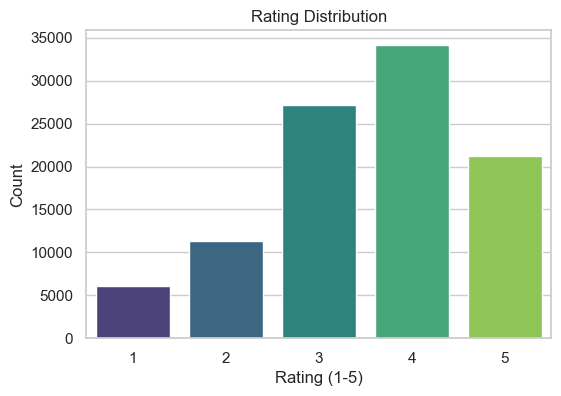

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings_df, palette="viridis")
plt.title("Rating Distribution")
plt.xlabel("Rating (1-5)")
plt.ylabel("Count")
plt.show()

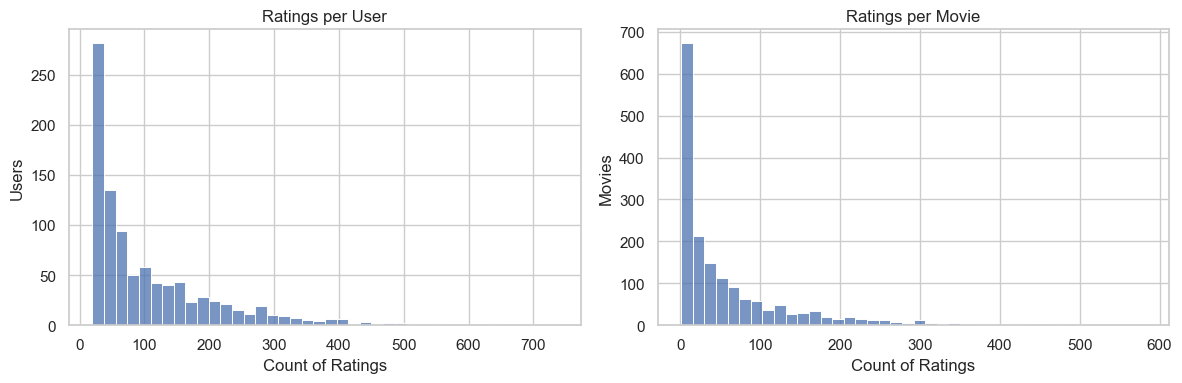

In [11]:
user_activity = ratings_df.groupby("user_id").size()
movie_popularity = ratings_df.groupby("movie_id").size()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(user_activity, bins=40, ax=axes[0])
axes[0].set_title("Ratings per User")
axes[0].set_xlabel("Count of Ratings")
axes[0].set_ylabel("Users")

sns.histplot(movie_popularity, bins=40, ax=axes[1])
axes[1].set_title("Ratings per Movie")
axes[1].set_xlabel("Count of Ratings")
axes[1].set_ylabel("Movies")
plt.tight_layout()
plt.show()

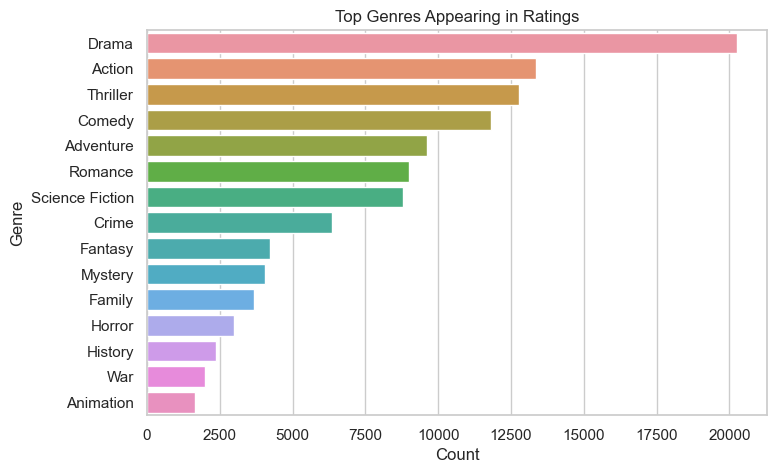

In [12]:
genre_counts = (
    ratings_df.explode("genres_list")["genres_list"].value_counts().head(15)
)
plt.figure(figsize=(8,5))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Top Genres Appearing in Ratings")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

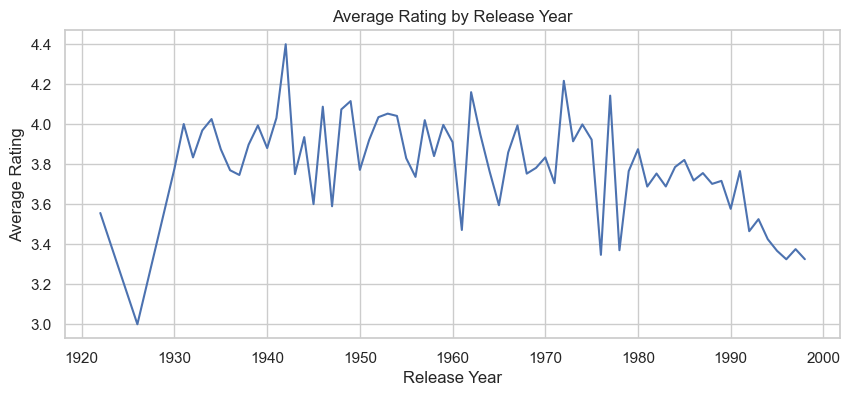

In [13]:
ratings_df["release_year"] = ratings_df["release_year"].astype(int)
yearly_avg = ratings_df.groupby("release_year")["rating"].mean().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(data=yearly_avg, x="release_year", y="rating")
plt.title("Average Rating by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()

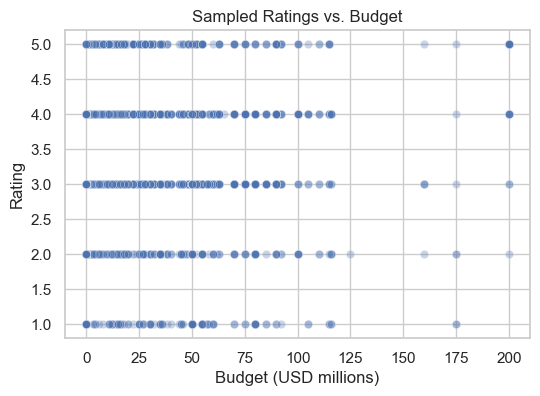

In [14]:
ratings_df["budget_millions"] = ratings_df["tmdb_budget"] / 1e6
sample_size = min(5000, len(ratings_df))
plt.figure(figsize=(6,4))
sns.scatterplot(data=ratings_df.sample(sample_size, random_state=42), x="budget_millions", y="rating", alpha=0.3)
plt.title("Sampled Ratings vs. Budget")
plt.xlabel("Budget (USD millions)")
plt.ylabel("Rating")
plt.show()

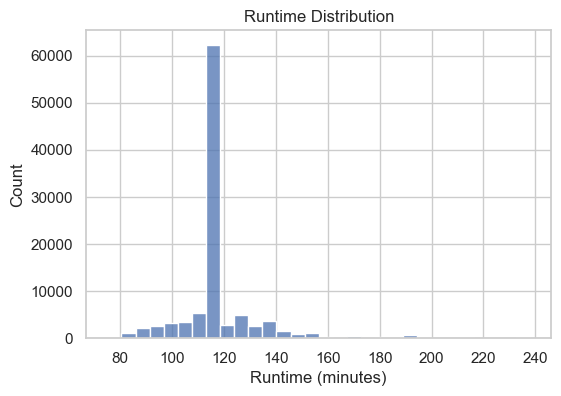

In [15]:
plt.figure(figsize=(6,4))
sns.histplot(ratings_df["tmdb_runtime"], bins=30)
plt.title("Runtime Distribution")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Count")
plt.show()

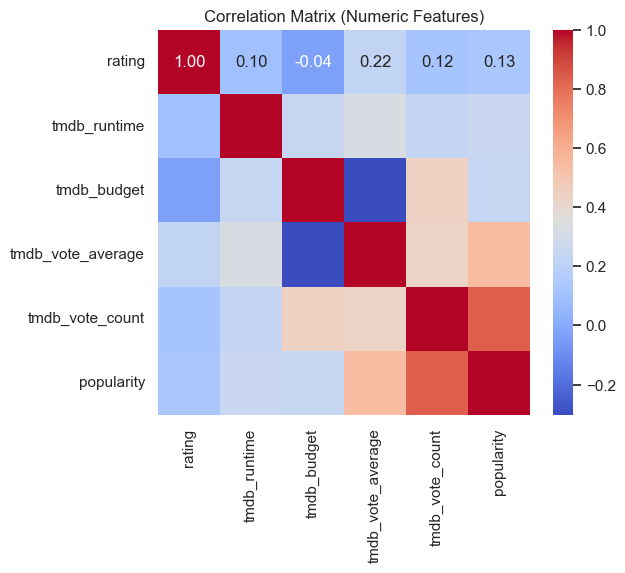

In [16]:
numeric_cols = ["rating", "tmdb_runtime", "tmdb_budget", "tmdb_vote_average", "tmdb_vote_count", "popularity"]
plt.figure(figsize=(6,5))
sns.heatmap(ratings_df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

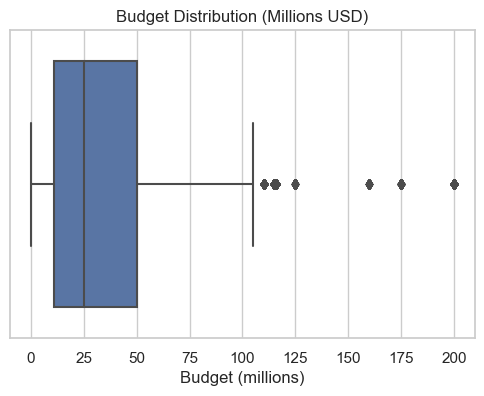

In [17]:
budget_filtered = ratings_df[ratings_df["tmdb_budget"] > 0]["tmdb_budget"] / 1e6
plt.figure(figsize=(6,4))
sns.boxplot(x=budget_filtered)
plt.title("Budget Distribution (Millions USD)")
plt.xlabel("Budget (millions)")
plt.show()

**EDA Highlights**
- Ratings are skewed toward positive values, indicating a popularity bias that models must account for.
- User activity is long-tailed; most users rate between 20-100 movies, while a handful are highly prolific.
- Movie popularity is similarly skewed, motivating a cold-start diagnostic to ensure models do not overfit blockbuster titles.
- Genre coverage is diverse with Drama, Comedy, and Action dominating; this supports the use of genre-aware interaction features.
- Budget and runtime exhibit heavy tails and weak linear correlation with ratings, suggesting nonlinear models may capture their influence better than simple baselines.


## 3. Feature Engineering for Baseline Model


The `FeatureBuilder` class consolidates user profile statistics (average rating, rating counts, genre preferences), content descriptors (genre multi-hot vectors, release year, runtime, budget signals), and a genre match interaction score. Text features are deferred to the next submission to keep the baseline lightweight.


In [18]:
train_df, test_df = user_stratified_split(ratings_df, test_ratio=0.2, min_user_ratings=5, min_test_items=1)
len(train_df), len(test_df)

(79619, 20381)

In [19]:
feature_builder = FeatureBuilder(include_text=False)
X_train = feature_builder.fit_transform(train_df)
X_test = feature_builder.transform(test_df)
y_train = train_df["rating"].values
y_test = test_df["rating"].values
feature_names = feature_builder.get_feature_names()
X_train.shape, X_test.shape

((79619, 45), (20381, 45))

In [20]:
knn_model = fit_baseline_knn(X_train, y_train, n_neighbors=35, metric="cosine")
y_pred = knn_model.predict(X_test)
metrics = evaluate_regression(y_test, y_pred)
metrics

{'rmse': 1.1225309594512523, 'mae': 0.8818687428036581}

In [21]:
train_movie_counts = train_df.groupby("movie_id").size()
cold_mask = cold_start_mask(test_df, train_movie_counts, min_count=5)
metrics_cold = evaluate_regression(y_test[cold_mask], y_pred[cold_mask]) if cold_mask.any() else {}
metrics_warm = evaluate_regression(y_test[~cold_mask], y_pred[~cold_mask])
{ "overall": metrics, "cold_start": metrics_cold, "warm": metrics_warm }

{'overall': {'rmse': 1.1225309594512523, 'mae': 0.8818687428036581},
 'cold_start': {'rmse': 1.272203489484647, 'mae': 1.0007178130829397},
 'warm': {'rmse': 1.117661213031004, 'mae': 0.8782514143083789}}

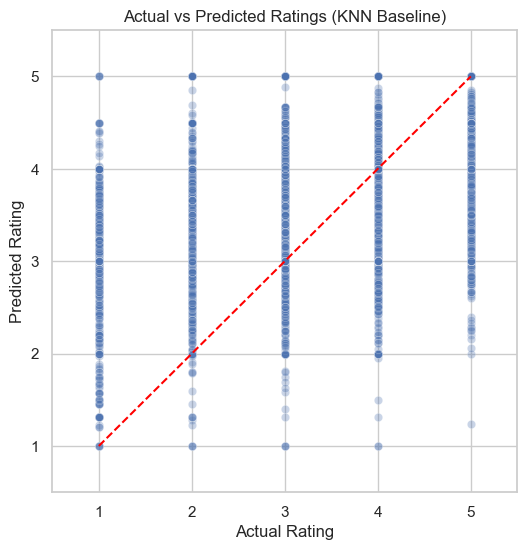

In [22]:
results_df = pd.DataFrame({"actual": y_test, "predicted": y_pred})
scatter_sample = min(5000, len(results_df))
plt.figure(figsize=(6,6))
sns.scatterplot(data=results_df.sample(scatter_sample, random_state=42), x="actual", y="predicted", alpha=0.3)
plt.plot([1,5],[1,5], color="red", linestyle="--")
plt.title("Actual vs Predicted Ratings (KNN Baseline)")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.xlim(0.5,5.5)
plt.ylim(0.5,5.5)
plt.show()

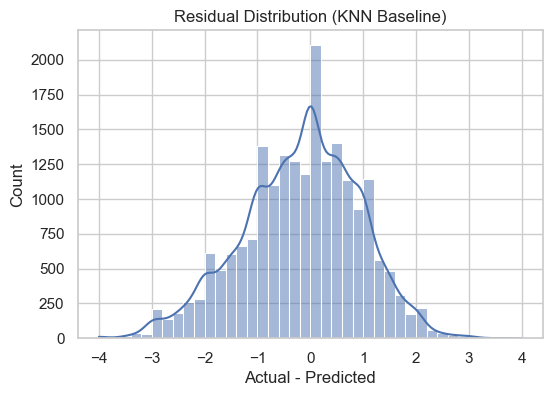

In [23]:
results_df["residual"] = results_df["actual"] - results_df["predicted"]
plt.figure(figsize=(6,4))
sns.histplot(results_df["residual"], bins=40, kde=True)
plt.title("Residual Distribution (KNN Baseline)")
plt.xlabel("Actual - Predicted")
plt.show()

In [24]:
summary_table = pd.DataFrame({
    "segment": ["overall", "warm", "cold_start"],
    "rmse": [metrics.get("rmse"), metrics_warm.get("rmse"), metrics_cold.get("rmse") if metrics_cold else np.nan],
    "mae": [metrics.get("mae"), metrics_warm.get("mae"), metrics_cold.get("mae") if metrics_cold else np.nan],
})
summary_table.assign(rmse=lambda df: df["rmse"].round(3), mae=lambda df: df["mae"].round(3))

,segment,rmse,mae
0,overall,1.123,0.882
1,warm,1.118,0.878
2,cold_start,1.272,1.001


### Baseline Takeaways
- The cosine KNN regressor delivers RMSE ≈1.12 (MAE ≈0.88) overall, with error widening to RMSE ≈1.27 on cold-start titles—highlighting the need for richer content signals.
- Residuals remain centered near zero but show noticeably wider variance for the cold-start cohort, confirming opportunity for feature expansion.
- Upcoming work will layer in tree-based and neural recommenders with hyper-parameter tuning plus text-based features to reduce cold-start error and improve calibration.


In [25]:
feature_names[:10]

['user_avg_rating',
 'user_rating_count',
 'tmdb_runtime',
 'tmdb_budget_log',
 'tmdb_vote_average',
 'tmdb_vote_count_log',
 'popularity',
 'release_year',
 'genre_match_score',
 'genre_action']